# Transformer tap changer based on load flow results for the transformer

In this tuitorial, we describe a transformer tap control strategy in a Low-Voltage (LV) distribution grid with distributed generation. The concept of the tap changer control is based on reacting to the direction and magnitude of the power flowing through the transformer. If the power is flowing towards the grid, it signifies consumption and a voltage drop in the grid. In this situation, it is beneficial to increase the voltage setpoint for the transformer tap changer. Alternatively, if the power is flowing through the transformer out of the grid, it is likely that the voltage rises due to distributed generation. In this case, the voltage setpoint of the transformer tap changer can be reduced. This control strategy allows expanding the usable voltage band. The characteristic curve for the voltage setpoint can be configured to match the voltage behavior in the grid, potentially leading to a better utilization of the available voltage band, than if using the local control strategy (with only ContinuousTapControl or DiscreteTapControl).

In [4]:
import os
import numpy as np
import pandas as pd
import tempfile
import pandapower as pp
import pandapower.control
import pandapower.control as control
from pandapower.control import Characteristic, SplineCharacteristic
from pandapower.control.util.auxiliary import plot_characteristic
from scipy.interpolate import interp1d

First, we crate an example grid with a load and a static generator:

In [5]:
net = pp.create_empty_network() 
for i in range(4):
    if i < 2:
        vn=110
    else:
        vn=20
    pp.create_bus(net, name='Bus %s' % i, vn_kv=vn, type="n")
pp.create_line(net, 0, 1, length_km=10, std_type="149-AL1/24-ST1A 110.0",name="Line 1")
pp.create_line(net, 2, 3, length_km=10, std_type="184-AL1/30-ST1A 20.0",name="Line 2")
pp.create_ext_grid(net, 0, vm_pu=1.02, va_degree=50)   
trafo = pp.create_transformer(net, 1, 2, name="110kV/20kV transformer", std_type="25 MVA 110/20 kV")
pp.create_load(net, 3, p_mw=35, q_mvar=4, scaling=1, name="load")
pp.create_sgen(net, 3, p_mw=10, q_mvar=3,  name="generator") 
net.bus

,name,vn_kv,type,zone,in_service,geo
0,Bus 0,110.0,n,None,True,None
1,Bus 1,110.0,n,None,True,None
2,Bus 2,20.0,n,None,True,None
3,Bus 3,20.0,n,None,True,None


We use a ContiniousTapControl controller to adjust the transformer tap position and we set the voltage setpoint to 0.98 p. u.

In [6]:
trafo_controller = control.ContinuousTapControl(net, 0, 0.98, tol=1e-6)

An object of class Characteristic can be used to provide a function for the voltage setpoint in relation to the input variable. The function is a piecewise linear characteristic. In this case, the characteristic represents the voltage setpoint depending on the active power flowing through the transformer:

In [7]:
c = Characteristic(net, x_values=[-20, -15, -5, 5,15, 20], y_values=[0.92, 0.97, 0.98, 1.02, 1.03, 1.08])

We can obtain the exact voltage setpoint that corresponds to a certain input value by calling it. For example, the voltage setpoint for the active power of 0 MW is 1.0 p. u.

In [8]:
c(x=0)

1.0

The Characteristic can be displayed visually:

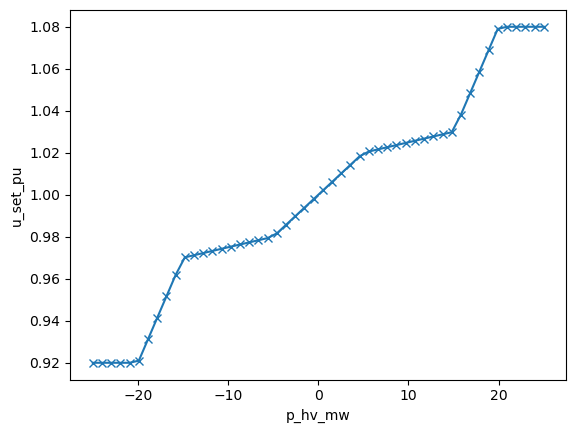

In [9]:
plot_characteristic(c,-25,25,50, 'p_hv_mw', 'u_set_pu')

We use an additional controller of class USetTapControl to adjust the voltage setpoint of the ContinuousTapControl based on the defined Characteristic. It is possible to use any variable from the transformer results table, the standard variable is p_hv_mw.

In [10]:
tc = control.VmSetTapControl(net, 0, characteristic_index=c.index, tol=0.0005)

Now, we can run the calculation and verify the results for different load flow situations.

In [11]:
pp.runpp(net, run_control=True)
print(f"The load has active power of {net.load.at[0, 'p_mw']} MW, sgen has active power of {net.sgen.at[0, 'p_mw']} MW")
print(f"Power flowing through the transformer is {net.res_trafo.at[0, 'p_hv_mw']:.2f} MW")
print(f"Voltage setpoint from Characteristic is {c(x=net.res_trafo.at[0, 'p_hv_mw']):.3f} p. u.")
print(f"Voltage at the controlled bus is {net.res_bus.at[2, 'vm_pu']:.3f} p. u.")
print(f"Transformer tap position is {net.trafo.at[0, 'tap_pos']:.2f}")
net.res_bus

The load has active power of 35.0 MW, sgen has active power of 10.0 MW
Power flowing through the transformer is 27.88 MW
Voltage setpoint from Characteristic is 1.080 p. u.
Voltage at the controlled bus is 1.080 p. u.
Transformer tap position is -6.47


,vm_pu,va_degree,p_mw,q_mvar
0,1.020000,50.000000,-28.015006,-10.07003
1,1.012223,49.564345,0.000000,0.00000
2,1.079999,-106.697190,0.000000,0.00000
3,0.946174,-118.118158,25.000000,1.00000


In [12]:
net.load.at[0, 'p_mw'] = 20
pp.runpp(net, run_control=True)
print(f"The load has active power of {net.load.at[0, 'p_mw']} MW, sgen has active power of {net.sgen.at[0, 'p_mw']} MW")
print(f"Power flowing through the transformer is {net.res_trafo.at[0, 'p_hv_mw']:.2f} MW")
print(f"Voltage setpoint from Characteristic is {c(x=net.res_trafo.at[0, 'p_hv_mw']):.3f} p. u.")
print(f"Voltage at the controlled bus is {net.res_bus.at[2, 'vm_pu']:.3f} p. u.")
print(f"Transformer tap position is {net.trafo.at[0, 'tap_pos']:.2f}")
net.res_bus

The load has active power of 20.0 MW, sgen has active power of 10.0 MW
Power flowing through the transformer is 10.45 MW
Voltage setpoint from Characteristic is 1.025 p. u.
Voltage at the controlled bus is 1.025 p. u.
Transformer tap position is -1.25


,vm_pu,va_degree,p_mw,q_mvar
0,1.020000,50.000000,-10.468562,-2.080746
1,1.017611,49.824140,0.000000,0.000000
2,1.025451,-102.855151,0.000000,0.000000
3,0.973503,-107.370899,10.000000,1.000000


In [13]:
net.load.at[0, 'p_mw'] = 0
pp.runpp(net, run_control=True)
print(f"The load has active power of {net.load.at[0, 'p_mw']} MW, sgen has active power of {net.sgen.at[0, 'p_mw']} MW")
print(f"Power flowing through the transformer is {net.res_trafo.at[0, 'p_hv_mw']:.2f} MW")
print(f"Voltage setpoint from Characteristic is {c(x=net.res_trafo.at[0, 'p_hv_mw']):.3f} p. u.")
print(f"Voltage at the controlled bus is {net.res_bus.at[2, 'vm_pu']:.3f} p. u.")
print(f"Transformer tap position is {net.trafo.at[0, 'tap_pos']:.2f}")
net.res_bus

The load has active power of 0.0 MW, sgen has active power of 10.0 MW
Power flowing through the transformer is -9.58 MW
Voltage setpoint from Characteristic is 0.975 p. u.
Voltage at the controlled bus is 0.975 p. u.
Transformer tap position is 2.50


,vm_pu,va_degree,p_mw,q_mvar
0,1.020000,50.000000,9.560748,-1.99191
1,1.020790,50.197370,0.000000,0.00000
2,0.975424,-97.034692,0.000000,0.00000
3,1.002610,-91.966170,-10.000000,1.00000


Next, we demonstrate the usage of the current as the input instead of active power. To this end, we define a new Characteristic and a new USetTapControl.

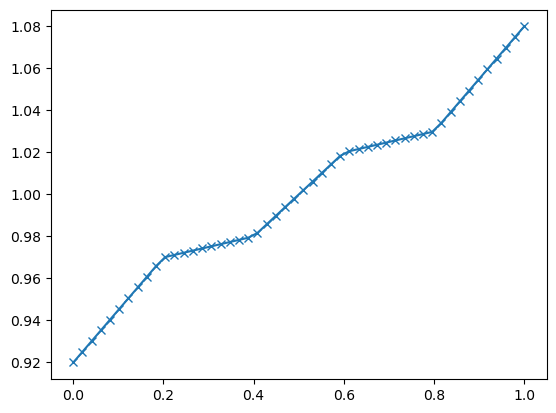

In [14]:
net.controller.at[tc.index, 'in_service'] = False
c1 = Characteristic(net, x_values=[0, 0.2, 0.4, 0.6, 0.8, 1], y_values=[0.92, 0.97, 0.98, 1.02, 1.03, 1.08])
tc1 = control.VmSetTapControl(net, 0, variable='i_lv_ka', characteristic_index=c1.index, tol=0.0005)
plot_characteristic(c1,0,1,50)

In [15]:
net.load.at[0, 'p_mw'] = 0
pp.runpp(net, run_control=True)
print(f"The load has active power of {net.load.at[0, 'p_mw']} MW, sgen has active power of {net.sgen.at[0, 'p_mw']} MW")
print(f"Current flowing through the transformer is {net.res_trafo.at[0, 'i_lv_ka']:.2f} kA")
print(f"Voltage setpoint from Characteristic is {c1(x=net.res_trafo.at[0, 'i_lv_ka']):.3f} kA")
print(f"Voltage at the controlled bus is {net.res_bus.at[2, 'vm_pu']:.3f} p. u.")
print(f"Transformer tap position is {net.trafo.at[0, 'tap_pos']:.2f}")
net.res_bus

The load has active power of 0.0 MW, sgen has active power of 10.0 MW
Current flowing through the transformer is 0.29 kA
Voltage setpoint from Characteristic is 0.974 kA
Voltage at the controlled bus is 0.974 p. u.
Transformer tap position is 2.56


,vm_pu,va_degree,p_mw,q_mvar
0,1.020000,50.000000,9.560012,-1.994347
1,1.020789,50.197378,0.000000,0.000000
2,0.974478,-97.029566,0.000000,0.000000
3,1.001682,-91.951390,-10.000000,1.000000


The load has active power of 20.0 MW, sgen has active power of 10.0 MW
Current flowing through the transformer is 0.32 kA
Voltage setpoint from Characteristic is 0.976 kA
Voltage at the controlled bus is 0.976 p. u.
Transformer tap position is 1.96


,vm_pu,va_degree,p_mw,q_mvar
0,1.020000,50.000000,-10.519196,-2.246655
1,1.017547,49.824651,0.000000,0.000000
2,0.975757,-103.142265,0.000000,0.000000
3,0.920431,-108.162692,10.000000,1.000000


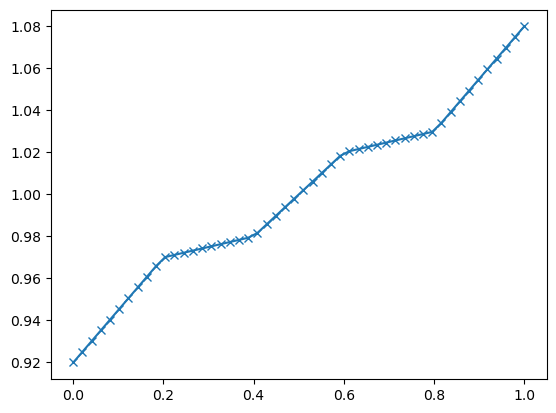

In [16]:
net.load.at[0, 'p_mw'] = 20
plot_characteristic(c1,0,1,50)
pp.runpp(net, run_control=True)
print(f"The load has active power of {net.load.at[0, 'p_mw']} MW, sgen has active power of {net.sgen.at[0, 'p_mw']} MW")
print(f"Current flowing through the transformer is {net.res_trafo.at[0, 'i_lv_ka']:.2f} kA")
print(f"Voltage setpoint from Characteristic is {c1(x=net.res_trafo.at[0, 'i_lv_ka']):.3f} kA")
print(f"Voltage at the controlled bus is {net.res_bus.at[2, 'vm_pu']:.3f} p. u.")
print(f"Transformer tap position is {net.trafo.at[0, 'tap_pos']:.2f}")
net.res_bus

In [17]:
net.load.at[0, 'p_mw'] = 35
pp.runpp(net, run_control=True)
print(f"The load has active power of {net.load.at[0, 'p_mw']} MW, sgen has active power of {net.sgen.at[0, 'p_mw']} MW")
print(f"Current flowing through the transformer is {net.res_trafo.at[0, 'i_lv_ka']:.2f} kA")
print(f"Voltage setpoint from Characteristic is {c1(x=net.res_trafo.at[0, 'i_lv_ka']):.3f} kA")
print(f"Voltage at the controlled bus is {net.res_bus.at[2, 'vm_pu']:.3f} p. u.")
print(f"Transformer tap position is {net.trafo.at[0, 'tap_pos']:.2f}")
net.res_bus

The load has active power of 35.0 MW, sgen has active power of 10.0 MW
Current flowing through the transformer is 0.81 kA
Voltage setpoint from Characteristic is 1.033 kA
Voltage at the controlled bus is 1.033 p. u.
Transformer tap position is -4.25


,vm_pu,va_degree,p_mw,q_mvar
0,1.020000,50.000000,-28.407864,-11.319413
1,1.011746,49.567870,0.000000,0.000000
2,1.033311,-107.308710,0.000000,0.000000
3,0.888076,-120.047087,25.000000,1.000000


Now let's go ahead and use a non-linear function in place of the piecewise linear Characteristic. We will use the interp1d class from scipy.interpolate to substitute Characteristic in the controller USetTapControl.

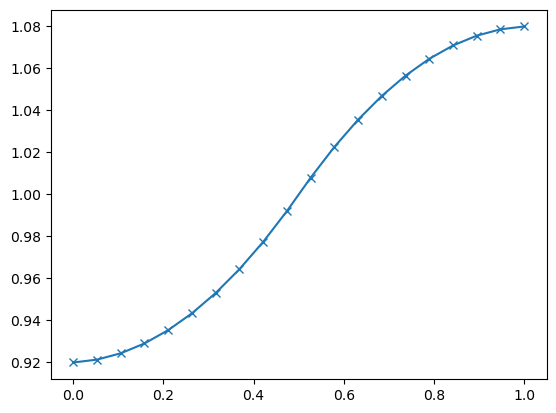

In [18]:
c2 = SplineCharacteristic(net, [0, 0.3, 0.7, 1], [0.92, 0.95, 1.05, 1.08])
plot_characteristic(c2,0,1)

In [19]:
tc1.characteristic_index = c2.index

In [20]:
net.load.at[0, 'p_mw'] = 35
pp.runpp(net, run_control=True)
print(f"The load has active power of {net.load.at[0, 'p_mw']} MW, sgen has active power of {net.sgen.at[0, 'p_mw']} MW")
print(f"Current flowing through the transformer is {net.res_trafo.at[0, 'i_lv_ka']:.2f} kA")
print(f"Voltage setpoint from Characteristic is {c2(x=net.res_trafo.at[0, 'i_lv_ka']):.3f} kA")
print(f"Voltage at the controlled bus is {net.res_bus.at[2, 'vm_pu']:.3f} p. u.")
print(f"Transformer tap position is {net.trafo.at[0, 'tap_pos']:.2f}")
net.res_bus

The load has active power of 35.0 MW, sgen has active power of 10.0 MW
Current flowing through the transformer is 0.78 kA
Voltage setpoint from Characteristic is 1.063 kA
Voltage at the controlled bus is 1.063 p. u.
Transformer tap position is -5.68


,vm_pu,va_degree,p_mw,q_mvar
0,1.020000,50.000000,-28.145166,-10.484178
1,1.012065,49.565514,0.000000,0.000000
2,1.063310,-106.905800,0.000000,0.000000
3,0.925665,-118.769199,25.000000,1.000000


As we can see, USetTapControl can be used with different functions to define the characteristic, as well as with different input variables.